In [1]:
# 1. Import libraries and load dataset
import pandas as pd
import io

df = pd.read_csv("MovieRecommendations.csv")
print("--- First 5 Rows ---")
print(df.head())

print("\n--- Data Info ---")
buffer = io.StringIO()
df.info(buf=buffer)
print(buffer.getvalue())

print("\n--- Missing Values ---")
print(df.isnull().sum())


--- First 5 Rows ---
                       title    rating  numOfRatings FirstMovieRecommendation  \
0  'Til There Was You (1997)  2.333333             9       Primal Fear (1996)   
1               1-900 (1994)  2.600000             5   Full Monty, The (1997)   
2      101 Dalmatians (1996)  2.908257           109    Murder at 1600 (1997)   
3        12 Angry Men (1957)  4.344000           125       Ulee's Gold (1997)   
4                 187 (1997)  3.024390            41          Maverick (1994)   

                   SecondMovieRecommendation       ThirdMovieRecommendation  \
0  Indiana Jones and the Last Crusade (1989)               Edge, The (1997)   
1                           Crow, The (1994)          Ice Storm, The (1997)   
2              Miracle on 34th Street (1994)             Being There (1979)   
3                         Rear Window (1954)    Seven Years in Tibet (1997)   
4                 Conan the Barbarian (1981)  Magnificent Seven, The (1954)   

        FourthMov

In [2]:
# 2. Data Preprocessing
# Fill missing numeric values
df['rating'] = df['rating'].fillna(df['rating'].median())
df['numOfRatings'] = df['numOfRatings'].fillna(df['numOfRatings'].median())

# Fill missing recommendations with a placeholder (or you could drop)
recommendation_cols = ['FirstMovieRecommendation', 'SecondMovieRecommendation',
                       'ThirdMovieRecommendation', 'FourthMovieRecommendation']
df[recommendation_cols] = df[recommendation_cols].fillna('Unknown')

# Convert recommendation columns into categorical encoding
for col in recommendation_cols:
    df[col] = pd.factorize(df[col])[0]

# Drop title column since it is text and not directly usable
df = df.drop('title', axis=1)

print("- - - Data Preprocessing Complete - - -")


- - - Data Preprocessing Complete - - -


In [3]:
# 3. Train-Test Split and Model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Regression for numeric target

# Let's predict numOfRatings
X = df.drop('numOfRatings', axis=1)
y = df['numOfRatings']

print("-- Final Features (Head) ---")
print(X.head())

feature_names = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("\n--- Model Training Complete ---")

-- Final Features (Head) ---
     rating  FirstMovieRecommendation  SecondMovieRecommendation  \
0  2.333333                         0                          0   
1  2.600000                         1                          1   
2  2.908257                         2                          2   
3  4.344000                         3                          3   
4  3.024390                         4                          4   

   ThirdMovieRecommendation  FourthMovieRecommendation  
0                         0                          0  
1                         1                          1  
2                         2                          2  
3                         3                          3  
4                         4                          4  

--- Model Training Complete ---


--- 1. RMSE ---
RMSE: 71.8369

--- 2. R2 Score ---
R2 Score: 0.1824

Predicted vs Actual plot saved as 'predicted_vs_actual.png'

Learning curves plot saved as 'learning_curves_movies.png'


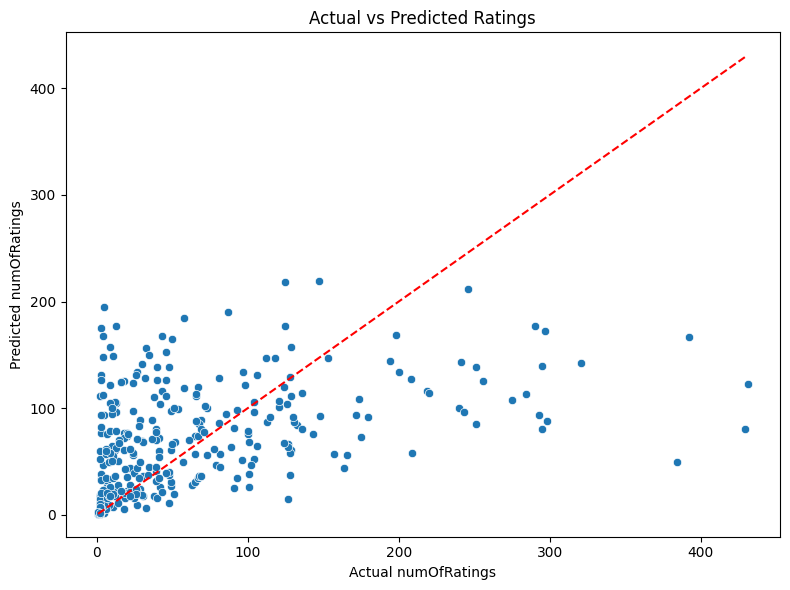

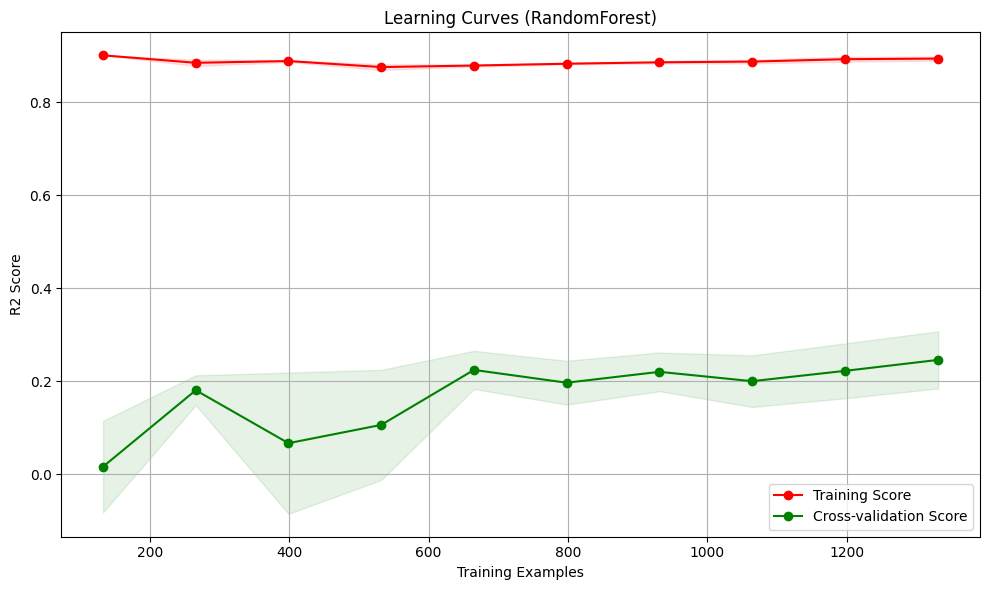

In [5]:
# 4. Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import numpy as np

y_pred = model.predict(X_test)

# Accuracy metrics for regression
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("--- 1. RMSE ---")
print(f"RMSE: {rmse:.4f}")
print("\n--- 2. R2 Score ---")
print(f"R2 Score: {r2:.4f}")

# Plot predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual numOfRatings")
plt.ylabel("Predicted numOfRatings")
plt.title("Actual vs Predicted Ratings")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.savefig("predicted_vs_actual.png")
print("\nPredicted vs Actual plot saved as 'predicted_vs_actual.png'")
# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='r2',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.figure(figsize=(10,6))
plt.title("Learning Curves (RandomForest)")
plt.xlabel("Training Examples")
plt.ylabel("R2 Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean-validation_scores_std, validation_scores_mean+validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation Score")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learning_curves_movies.png")
print("\nLearning curves plot saved as 'learning_curves_movies.png'")
